In [116]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import seaborn as sns
import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'
from time import time

import losses

In [118]:
filename_out    = 'output/ff_nn_per_shape.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 64
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_feature  = 1.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 10
#
exponent_clamping = 3.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [119]:
def read_data(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    labels = torch.zeros(len(files), 512, dtype = torch.float32)
    inputs = torch.zeros(len(files), 10, dtype = torch.float32)
    input_keys = ['shape', 'radius', 'radius_pd','length', 'length_pd',  'volfraction']
    for i,f in enumerate(files):
        with  h5py.File(os.path.join(path,f),'r') as file:
            print(file, end = '\r')
            labels[i,:] = torch.from_numpy(file['entry/I'][()].flatten())#I_noisy
            for i_k, key in enumerate(input_keys):
                try:
                    if key == 'shape':
                        shape = file['properties'][key][()].decode("utf-8")
                        if shape == 'sphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([1,0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([0,1,0])
                        else:
                            inputs[i, i_k:i_k+3] = torch.tensor([0,0,1])
                    elif key =='radius':
                        if shape == 'sphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([file['properties'][key][()],0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,file['properties'][key][()],0])
                        else:
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,0,file['properties'][key][()]])
                    else:
                        inputs[i, i_k+4] = file['properties'][key][()]
                except KeyError:
                    # spheres don't have all of the properties a cylinder does
                    pass
    return inputs, labels
            

In [120]:
inputs,labels = read_data('/home/slaskina/simulations')

In [121]:
def extract_shape(shape):
    if shape == 'sphere':
        return inputs[inputs[:,0]==1][:, 3:], labels[inputs[:,0]==1]
    elif shape == 'hardsphere':
        return inputs[inputs[:,1]==1][:, 3:], labels[inputs[:,1]==1]
    else:
        return inputs[inputs[:,2]==1][:, 3:], labels[inputs[:,2]==1]

In [122]:
def create_loaders(inputs, labels):
    # Creating data indices for training and validation splits:
    dataset_size = len(labels)
    indices = list(range(dataset_size))
    test_size = 0.1
    val_size = 0.2
    test_split = int(np.floor(test_size * dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    np.random.seed(1234)
    np.random.shuffle(indices)
    train_indices, val_indices, test_indices = indices[:dataset_size-test_split-val_split], indices[dataset_size-test_split-val_split:dataset_size-test_split], indices[dataset_size-test_split:]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(labels, inputs), batch_size=batch_size, drop_last=True, sampler = val_sampler)

    train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset( labels, inputs), batch_size=batch_size, drop_last=True, sampler = train_sampler)

    return train_indices, val_indices, test_indices,  test_loader, train_loader

In [123]:
class ForwardScatteringConvolutional(nn.Module):
    def __init__(self, N_blocks) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.sequence_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU()
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 7),
            nn.ELU()
        )
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            x =  self.sequence_block(x)
        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,7)

In [136]:
model_simple_conv_sphere = ForwardScatteringConvolutional(5).to(device)
model_simple_conv_hardsphere = ForwardScatteringConvolutional(5).to(device)
model_simple_conv_cylinder = ForwardScatteringConvolutional(5).to(device)

In [125]:
def params_trainable(model):
    params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
    for p in params_trainable:
        p.data = init_scale * torch.randn(p.data.shape).to(device)
    return params_trainable

def optimizer(model):
    optim = torch.optim.Adam(params_trainable(model), lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
    return optim 

gamma = (final_decay)**(1./n_epochs)

def optim_step(optim):
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def save(name, model, optim):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name, model, optim):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [126]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)


def loss_forward_mmd( x_features, pred):
    MMD_features = losses.backward_mmd(x_features, pred)
    if mmd_back_weighted:
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(pred, pred))
    return lambd_mmd_for_feature * torch.mean(MMD_features)

def train_epoch(model, optim, i_epoch, loader,  test=False):
    if not test:
        model.train()

    if test:
        model.eval()
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for y,x in loader: # because y is  actualy the result of x

        if batch_idx > n_its_per_epoch:
            break

        batch_idx += 1

        x, y = x.to(device), y.to(device)


        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
     
        pred = model(y).reshape(-1,7)
        loss = loss_forward_mmd(x, pred)
        loss_history.append([loss.item()]) # lisr of lists: list for each batch
        
        if not test:
            loss.backward()
            optim_step(optim)

    if test:
        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train(model, optim, train_loader, test_loader):

    try:
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(model, optim, i_epoch, train_loader) # mean over batches
            test_losses  = train_epoch(model, optim, i_epoch, test_loader, test=True)
            t = np.concatenate([train_losses, test_losses])
            print('Epoch {i_e}: training loss: {tl}, test loss: {testl}'.format(i_e = i_epoch, tl = t[0], testl = t[1]))


    except:
        save(filename_out + '_ABORT',model, optim)
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out,model, optim)


In [127]:
def make_prediction(labels, model):
    return model(labels)


In [128]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes, create_table_from_outcome

In [129]:
def violinplot_feature_shape(df_test,  sampled_inputs, feature):
    """
    Feature is either shape name, which will yield the radius
    or the one of the keys in the `indexer`.
    """
    indexer = {'radius_pd'   :3,
                'length'     :4,
                'length_pd'  :5,
                'volfraction':6}
    if feature =='sphere':
        pred = df_test[:, 0]
        sampled = sampled_inputs[:, 0]
    elif feature == 'hardsphere':
        pred = df_test[:, 1]
        sampled = sampled_inputs[:, 1]
    elif feature == 'cylinder':
        pred = df_test[:, 2]
        sampled = sampled_inputs[:, 2]
    else:
        pred = df_test[:, indexer[feature]]
        sampled = sampled_inputs[:, indexer[feature]]
    df = pd.concat([pd.DataFrame({'value': sampled, 'feature':'sampled'}),pd.DataFrame({'value': pred, 'feature':'predicted'})])
    sns.violinplot(df, y = 'value', x = 'feature') # can't generalize

## sphere

In [130]:
inputs_sphere,labels_sphere =  extract_shape('sphere')

In [131]:
train_indices_sphere, val_indices_sphere, test_indices_sphere,  test_loader_sphere, train_loader_sphere = create_loaders(inputs_sphere,labels_sphere)

In [132]:
train(model_simple_conv_sphere, optimizer(model_simple_conv_sphere), train_loader_sphere, test_loader_sphere)

Epoch 0: training loss: 1.6590135439678475, test loss: 0.13146322270234426
Epoch 1: training loss: 0.0961386394445543, test loss: 0.10960091948509217
Epoch 2: training loss: 0.088580130426972, test loss: 0.10555134266614914
Epoch 3: training loss: 0.09976771142747667, test loss: 0.10443555215994517
Epoch 4: training loss: 0.09380189515650272, test loss: 0.10622515256206194
Epoch 5: training loss: 0.10475046753331467, test loss: 0.10398191958665848
Epoch 6: training loss: 0.09500970277521345, test loss: 0.12324104160070419
Epoch 7: training loss: 0.09480297096349576, test loss: 0.10172137667735417
Epoch 8: training loss: 0.09506411843553737, test loss: 0.10111109266678492
Epoch 9: training loss: 0.09463202863655708, test loss: 0.10034489581982295
Epoch 10: training loss: 0.09795764026542504, test loss: 0.10337639401356379
Epoch 11: training loss: 0.0946655134084048, test loss: 0.10832997312148412
Epoch 12: training loss: 0.09249956554008855, test loss: 0.1181603342294693
Epoch 13: train

In [133]:
df_test = make_prediction(labels[test_indices_sphere], model_simple_conv_sphere.to('cpu')).detach().numpy()

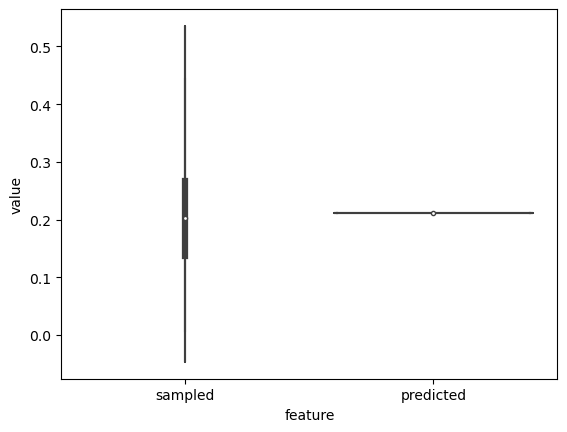

In [134]:
violinplot_feature_shape(df_test, inputs_sphere[test_indices_sphere], 'sphere')

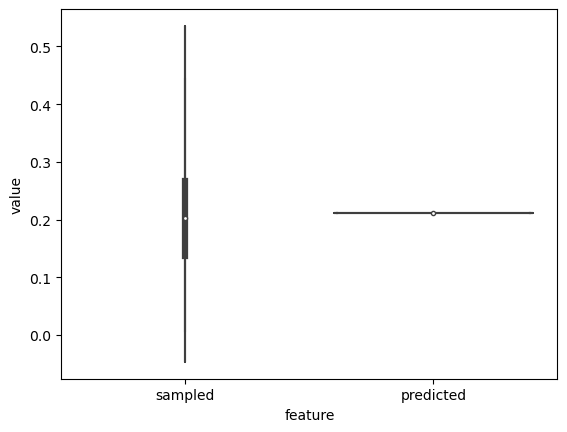

In [135]:
violinplot_feature_shape(df_test, inputs_sphere[test_indices_sphere], 'sphere')

## Hardsphere

In [137]:
inputs_hardsphere,labels_hardsphere =  extract_shape('hardsphere')
train_indices_hardsphere, val_indices_hardsphere, test_indices_hardsphere,  test_loader_hardsphere, train_loader_hardsphere = create_loaders(inputs_hardsphere,labels_hardsphere)
train(model_simple_conv_hardsphere, optimizer(model_simple_conv_hardsphere),train_loader_hardsphere, test_loader_hardsphere)

Epoch 0: training loss: 1.3056219945903178, test loss: 0.24719288647174836
Epoch 1: training loss: 0.2567422343073068, test loss: 0.2552393078804016
Epoch 2: training loss: 0.25679975168572533, test loss: 0.2462403525908788
Epoch 3: training loss: 0.2678743865754869, test loss: 0.26846837302049004
Epoch 4: training loss: 0.26132805010786764, test loss: 0.24889394541581472
Epoch 5: training loss: 0.2557700210147434, test loss: 0.24184228877226513
Epoch 6: training loss: 0.2555735061566035, test loss: 0.27028557658195496
Epoch 7: training loss: 0.2520428537218659, test loss: 0.24601855675379436
Epoch 8: training loss: 0.2601337049294401, test loss: 0.24642925560474396
Epoch 9: training loss: 0.25499276209760596, test loss: 0.2625046342611313
Epoch 10: training loss: 0.2551476119293107, test loss: 0.2528097699085871
Epoch 11: training loss: 0.26620685861066534, test loss: 0.2552065392335256
Epoch 12: training loss: 0.2579064871425982, test loss: 0.27391178607940675
Epoch 13: training loss

In [139]:
df_test = make_prediction(labels[test_indices_hardsphere], model_simple_conv_hardsphere.to('cpu')).detach().numpy()

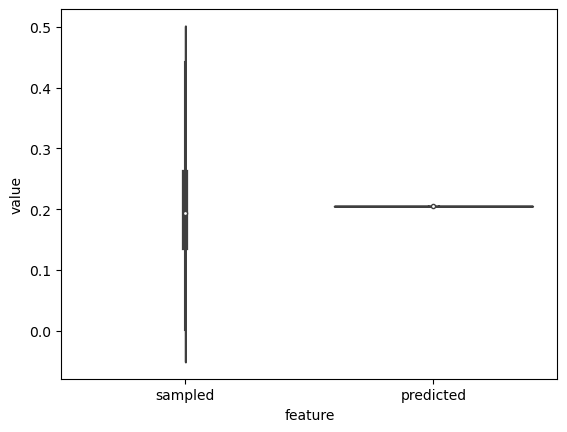

In [140]:
violinplot_feature_shape(df_test, inputs_hardsphere[test_indices_hardsphere], 'hardsphere')

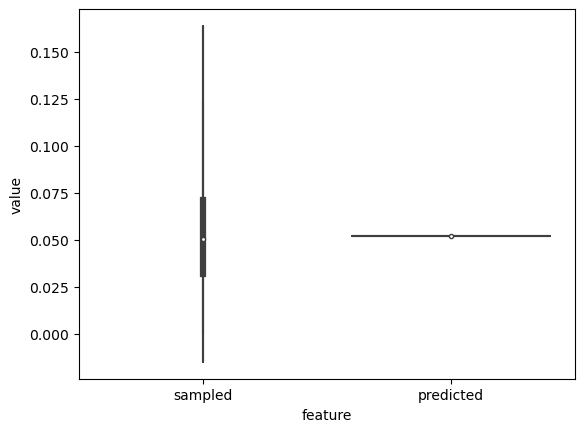

In [141]:
violinplot_feature_shape(df_test, inputs_hardsphere[test_indices_hardsphere], 'radius_pd')

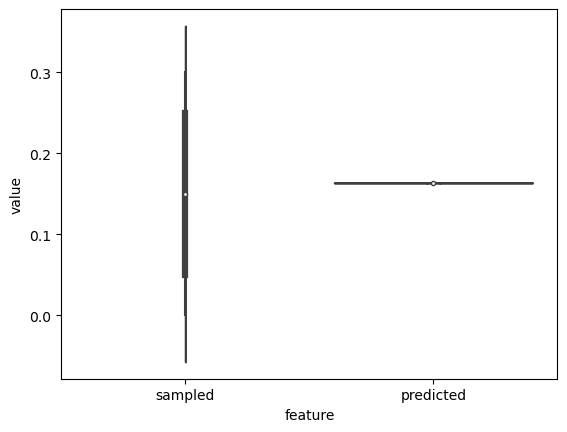

In [142]:
violinplot_feature_shape(df_test, inputs_hardsphere[test_indices_hardsphere], 'volfraction')

## Cylinder

In [144]:
inputs_cylinder,labels_cylinder =  extract_shape('cylinder')
train_indices_cylinder, val_indices_cylinder, test_indices_cylinder,  test_loader_cylinder, train_loader_cylinder = create_loaders(inputs_cylinder,labels_cylinder)
train(model_simple_conv_cylinder, optimizer(model_simple_conv_cylinder),train_loader_cylinder, test_loader_cylinder)

Epoch 0: training loss: 3.8177487320370145, test loss: 2.820312245686849
Epoch 1: training loss: 2.9442907351034657, test loss: 2.9893744468688963
Epoch 2: training loss: 2.8803969312597206, test loss: 3.0275205930074054
Epoch 3: training loss: 2.8910003149950945, test loss: 2.989099661509196
Epoch 4: training loss: 2.8991290551644786, test loss: 3.0443098545074463
Epoch 5: training loss: 2.8713219783924244, test loss: 2.905250358581543
Epoch 6: training loss: 2.871181536603857, test loss: 2.9818795839945476
Epoch 7: training loss: 2.865652830512435, test loss: 2.922273588180542
Epoch 8: training loss: 2.7536527713139853, test loss: 2.7761449019114175
Epoch 9: training loss: 2.093163276160205, test loss: 1.4794826745986938
Epoch 10: training loss: 0.9477358052024135, test loss: 0.6981538295745849
Epoch 11: training loss: 0.597331452148932, test loss: 0.5852737208207448
Epoch 12: training loss: 0.5273283510296433, test loss: 0.5080280343691508
Epoch 13: training loss: 0.5280509762190007

In [145]:
df_test = make_prediction(labels[test_indices_cylinder], model_simple_conv_cylinder.to('cpu')).detach().numpy()

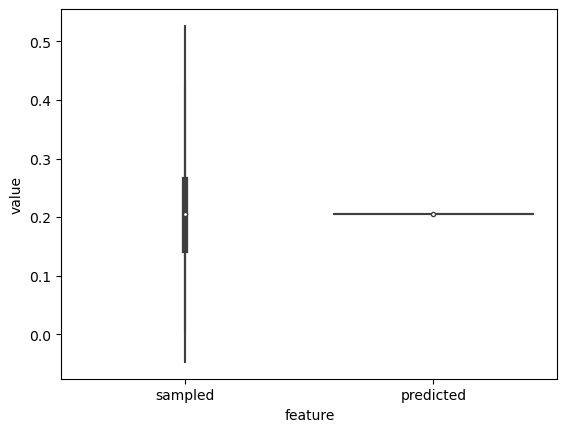

In [146]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'cylinder')

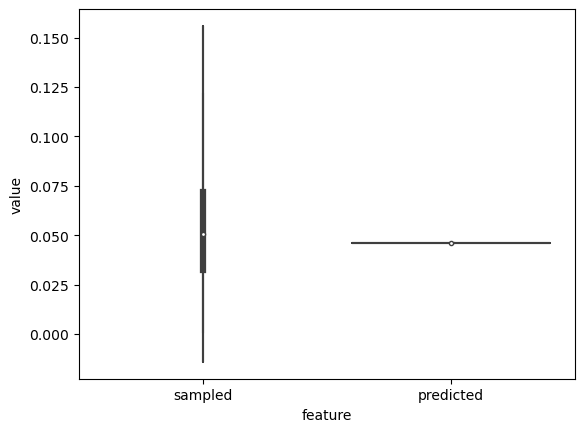

In [147]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'radius_pd')

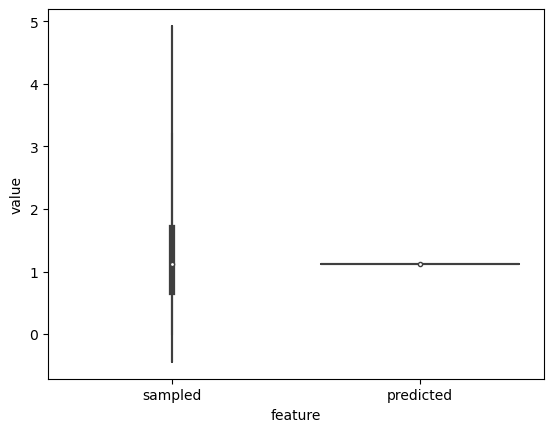

In [148]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'length')

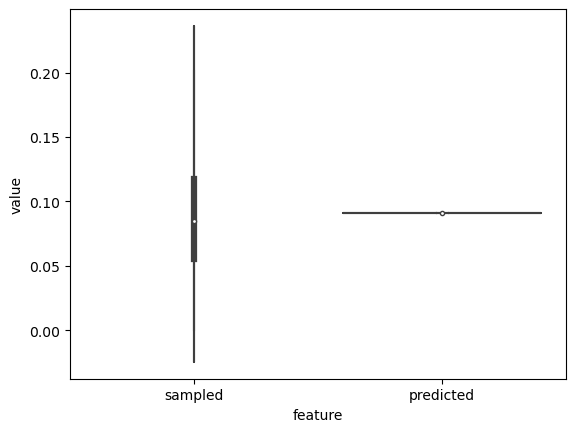

In [149]:
violinplot_feature_shape(df_test, inputs_cylinder[test_indices_cylinder], 'length_pd')